# Set up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2024-02-26 20:08:11.871115: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-26 20:08:11.898884: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-26 20:08:12.002420: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 20:08:12.002473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 20:08:12.018232: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# Vanishing/Exploding Gradients Problem

In [2]:
import numpy as np


def sigmoid(z):
    return 1 / (1 + np.exp(-z))

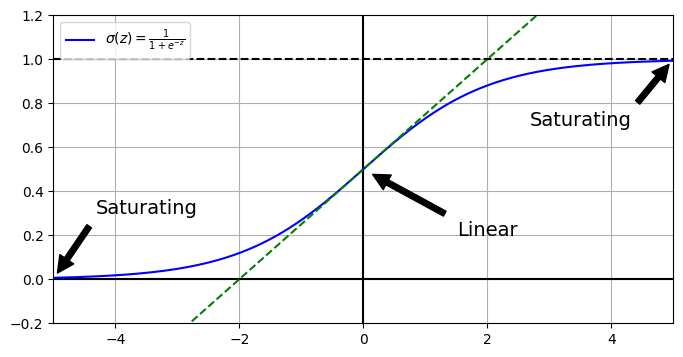

In [3]:
z = np.linspace(-5, 5, 1000)

plt.figure(figsize=(8, 4))
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([-5, 5], [1, 1], "k--")
plt.plot([0, 0], [-0.2, 1.2], "k-")
plt.plot(z, sigmoid(z), "b-", label=r"$\sigma(z) = \frac{1}{1 + e^{-z}}$")
plt.plot([-5, 5], [-3 / 4, 7 / 4], "g--")
props = dict(facecolor="black", shrink=0.1)
plt.annotate(
    "Saturating",
    xytext=(3.5, 0.7),
    xy=(5, 1),
    arrowprops=props,
    fontsize=14,
    ha="center",
)
plt.annotate(
    "Saturating",
    xytext=(-3.5, 0.3),
    xy=(-5, 0),
    arrowprops=props,
    fontsize=14,
    ha="center",
)
plt.annotate(
    "Linear", xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center"
)
plt.grid()
plt.legend(loc="upper left")
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

## Xavier and He initialization                

You can switch to your desired initialization by setting the `kernel_initializer` hyperparameter.

In [6]:
dense = tf.keras.layers.Dense(50, activation="relu", kernel_initializer="he_normal")

If you want to use He initialization with a uniform distribution and based on $fan_{avg}$ instead of $fan_{in}$, you can use the `VarianceScaling` initializer.

In [9]:
he_avg_init = tf.keras.initializers.VarianceScaling(
    scale=2.0, mode="fan_avg", distribution="uniform"
)
dense = tf.keras.layers.Dense(50, activation="sigmoid", kernel_initializer=he_avg_init)